# Working with highly imbalanced data

In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=3, suppress=True)

import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
sklearn.set_config(print_changed_only=True)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale, StandardScaler

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
# mammography dataset https://www.openml.org/d/310
data = pd.read_csv("data/mammography.csv")

In [3]:
target = data['class']

In [4]:
target.value_counts()

'-1'    10923
'1'       260
Name: class, dtype: int64

-1 = benign

1  = malignant

In [10]:
# target
y = (target != "'-1'").astype(np.int)
y.value_counts()

0    10923
1      260
Name: class, dtype: int64

In [7]:
# features
X = data.iloc[:, :-1]
X.shape

(11183, 6)

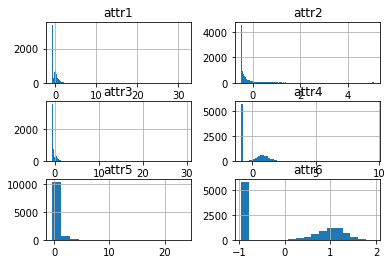

In [9]:
X.hist(bins='auto');

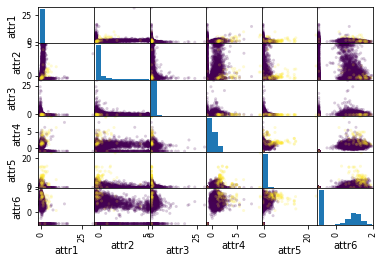

In [11]:
pd.plotting.scatter_matrix(X, c=y, alpha=.2);

### Train some models

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values, stratify=y, random_state=0)

In [14]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

scores = cross_validate(LogisticRegression(),
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))

scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9196227166963687, 0.6294963938533346)

In [15]:
from sklearn.ensemble import RandomForestClassifier
scores = cross_validate(RandomForestClassifier(n_estimators=100),
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))

scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9386901656502106, 0.7247318766142351)

### It looks like we're performing well for the AUC

Well...it's probably because our model is always guessing benign (-1)

Let's use some techniques to combat the imbalance.

In [20]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(replacement=False)
X_train_subsample, y_train_subsample = rus.fit_sample(X_train, y_train)

print(X_train.shape)
print(X_train_subsample.shape)
print(np.bincount(y_train_subsample))

ModuleNotFoundError: No module named 'imblearn'

## Can't get this damn `imblearn` install to work

In [ ]:
from imblearn.pipeline import make_pipeline as make_imb_pipeline

undersample_pipe = make_imb_pipeline(RandomUnderSampler(), LogisticRegression())
scores = cross_validate(undersample_pipe,
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))

scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_train_oversample, y_train_oversample = ros.fit_sample(X_train, y_train)

print(X_train.shape)
print(X_train_oversample.shape)
print(np.bincount(y_train_oversample))

In [ ]:
oversample_pipe = make_imb_pipeline(RandomOverSampler(), LogisticRegression())
scores = cross_validate(oversample_pipe,
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))

scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

In [ ]:
undersample_pipe_rf = make_imb_pipeline(RandomUnderSampler(), RandomForestClassifier(n_estimators=100))
scores = cross_validate(undersample_pipe_rf,
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))

scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

In [ ]:
oversample_pipe_rf = make_imb_pipeline(RandomOverSampler(), RandomForestClassifier(n_estimators=100))
scores = cross_validate(oversample_pipe_rf,
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))

scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

# Class Weights

In [21]:
scores = cross_validate(LogisticRegression(class_weight='balanced'),
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))

scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9175679201521627, 0.5874608083830397)

In [22]:
scores = cross_validate(RandomForestClassifier(n_estimators=100, class_weight='balanced'),
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9194343805887453, 0.7008313239270434)

# Resampled Ensembles

In [23]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

resampled_rf = BalancedRandomForestClassifier(n_estimators=100, random_state=0)

ModuleNotFoundError: No module named 'imblearn'

In [ ]:
scores = cross_validate(resampled_rf,
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

In [ ]:
GridSearchCV(scoring=('roc_auc', 'average_precision'), refit='average_precision')

In [ ]:
GridSearchCV(scoring=('roc_auc', 'average_precision'), refit=False)

# Exercise
Pick two or three of the models and strategies above, run grid-search (optimizing roc_auc or average precision), and
plot the roc curves and PR-curves for these models.